## Import

In [1]:
import torch.nn as nn
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm_n
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from copy import copy, deepcopy
from tqdm.notebook import tqdm, trange
#import ray

In [1]:
import torch

In [2]:
%load_ext autoreload
%autoreload 2

## Data

### Datasets

In [3]:
from community.data.datasets import get_datasets_symbols
from community.utils.plotting import plot_grid, create_gifs
from community.data.tasks import get_task_target, get_task_family_dict, get_factors_list
from community.utils.configs import configure_readouts
from community.common.models.ensembles import Community

In [4]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256

In [5]:
n_agents = 2
n_classes_per_digit = 10

n_classes = n_classes_per_digit * n_agents

data_config = {
    "data_size": np.array([30000, 5000]) * 2,
    "nb_steps": 50,
    "n_symbols": n_classes - 1,
    "symbol_type": "mod_5",
    "input_size": 60,
    "static": True,
    "common_input": True,
    "n_diff_symbols": n_agents,
    "parallel": False,
}

if data_config["static"]:
    data_config["nb_steps"] = 10
    data_config["data_size"] = [d for d in data_config["data_size"]]

n_bits = np.ceil(np.log2(n_classes)).astype(int)
# loaders, datasets = get_datasets_symbols(data_config, batch_size, use_cuda, plot=True)


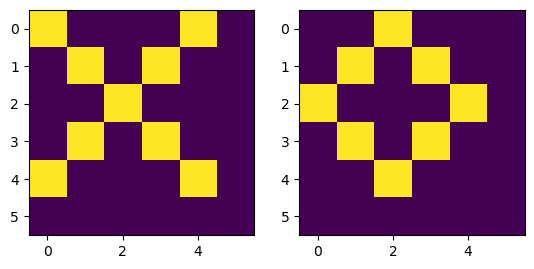

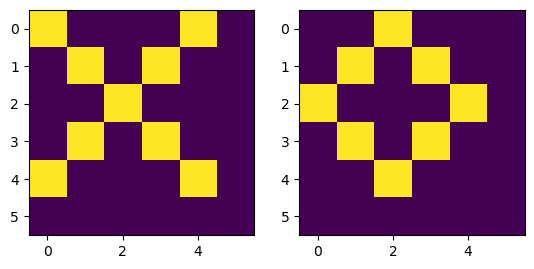

In [6]:
loaders, datasets = get_datasets_symbols(data_config, batch_size, use_cuda, plot=True)

### Plot

/home/gb21/.conda/envs/community2/lib/python3.9/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


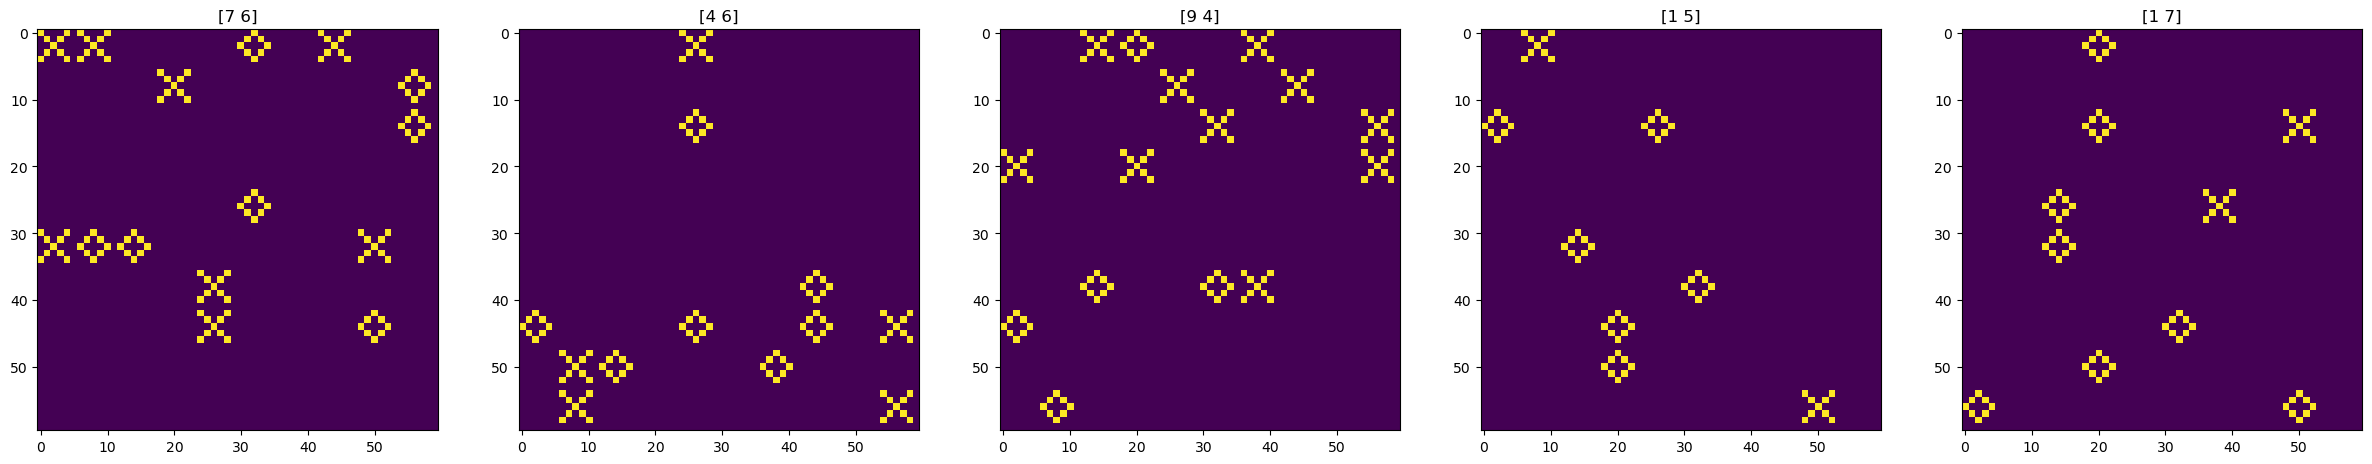

In [7]:
data, targets = datasets[0].data[:-1]
s = 50
fig, axs = plt.subplots(1, 5, figsize=(30, 20))
for i, ax in enumerate(axs):
    if not data_config["common_input"]:
        ax.imshow(data[i + s][-1].reshape(120, 60))
        ax.set_title(targets[i + s].data.numpy())
    else:
        ax.imshow(data[i + s][-1].reshape(60, 60))
        ax.set_title(targets[i + s].data.numpy())

## Init

In [106]:
from community.funcspec.single_model_loop import (
    init_and_train,
    train_and_compute_metrics,
    train_community,
    init_community,
    init_optimizers,
)

from community.data.process import process_data

from community.utils.configs import get_training_dict
import yaml
from yaml.loader import SafeLoader

with open("../../latest_config.yml", "r") as config_file:
    config = yaml.load(config_file, SafeLoader)

try shared goals with sum

Implement a task str-parsing function

In [117]:
# task = config["task"] = [ str(i) for i in range(n_agents)]  # "family"  # [[str(i), str((i+1)%3)] for i in range(3)]
# task = config["task"] = [['0', '1'], ['1', '2'], ['0', '2']] #"both"

task = config["task"] = "parity-both"

config["model"]["agents"]["n_in"] = data_config["input_size"] ** 2
n_hidden = config["model"]["agents"]["n_hidden"] = 25

# config["model"]["agents"].pop("n_hiddens")

config["model"]["n_agents"] = n_agents

common_readout = config["model"]["common_readout"] = True
config["model"]["readout_n_hid"] = None

config["datasets"]["n_classes"] = n_classes
config["datasets"]["n_classes_per_digit"] = n_classes_per_digit
config["datasets"]["symbol_config"]["n_diff_symbols"] = n_agents

configure_readouts(config)

config["model"]["connections"]["sparsity"] =  2 / n_hidden ** 2 # .005
config["model"]["connections"]["comms_out_scale"] = 1
config["model"]["connections"]["comms_start"] = "start"
config["model"]["connections"]["binarize"] = False


decision = config["training"]["decision"]
n_epochs = config["training"]["n_epochs"] = 15

In [118]:
community = init_community(config["model"])

reg_readout = 0

if not reg_readout:
    optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)

else:
    optimizer = torch.optim.AdamW(
        [p for n, p in community.named_parameters() if "readout" not in n], lr=1e-3
    )
    optimizer.add_param_group(
        {
            "params": [p for n, p in community.named_parameters() if "readout" in n],
            "lr": 1e-3,
            "weight_decay": reg_readout,
        }
    )

config["use_tqdm"] = True

community.nb_connections

{'01': tensor(2, device='cuda:0'), '10': tensor(2, device='cuda:0')}

In [119]:
data, target = next(iter(loaders[1]))
data, target = process_data(data, target, symbols=True, task=task)
data, target = data.to(device), target.to(device)

out, states, fconns = community(data)

print(out.shape, fconns.shape)

torch.Size([10, 2, 256, 10]) torch.Size([9, 2, 256, 25])


## Training

In [120]:
model_load = False
model_save = True

n_epochs = 15
community.to(device)


def train(n_epochs, test=False):
    return train_community(
        community,
        *loaders,
        optimizers=[optimizer, None],
        config=get_training_dict(config),
        n_epochs=n_epochs if not test else 1,
        trials=(not test, True),
        show_all_acc=True,
        use_tqdm=not test,
    )


try:
    saved_results = torch.load("saves/results")
    train_results = saved_results[str(config)]

    if model_load:
        community.load_state_dict(train_results["best_state"])
    else:
        train_results = train(n_epochs)

    if model_save:
        saved_results[str(config)] = train_results
        torch.save(saved_results, "saves/results")

except FileNotFoundError:
    # config["task"] = [str(i) for i in range(n_agents)]

    train_results = train(n_epochs)

    if model_save:
        saved_results = {}
        saved_results[str(config)] = train_results
        torch.save(saved_results, "saves/resuls")

except KeyError:
    train_results = train(n_epochs)
    saved_results[str(config)] = train_results
    if model_save:
        torch.save(saved_results, "saves/results")

testing_acc = train(1, True)["test_accs"]
print(f"Test Acc : {testing_acc}")


Train Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

Test Acc : [[0.99238783 0.9795673 ]]


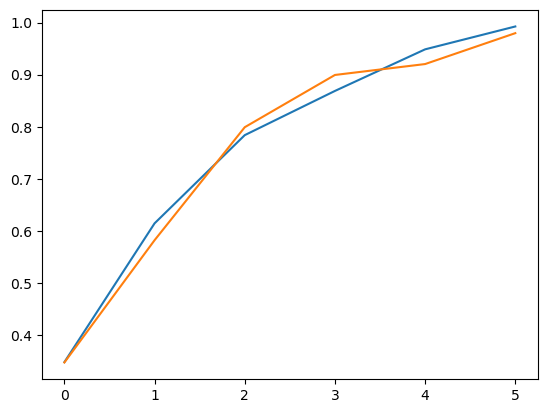

In [121]:
plt.plot(train_results["test_accs"])


In [14]:
raise StopIteration

StopIteration: 

## Readout Retraining : 

In [ ]:
task = config["task"] = "parity-digits"
config["model"]["readout_n_hid"] = 2

configure_readouts(config)


community.n_readouts = config["model"]["n_readouts"]


community.initialize_readout(
    config["model"]["n_readouts"],
    config["model"]["readout_from"],
    config["model"]["readout_n_hid"] = 2
)
                    
community.to(device)

config["training"]["n_epochs"] = 20
# config["task"] = [str(i) for i in range(n_agents)]

optimizer = torch.optim.Adam(
        [p for n, p in community.named_parameters() if "readout" in n],
        lr=1e-3,
    )


In [ ]:
train_results = train_community(
    community,
    *loaders,
    optimizers=[optimizer, None],
    config=get_training_dict(config),
    show_all_acc=True,
    use_tqdm=True,
)

Train Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

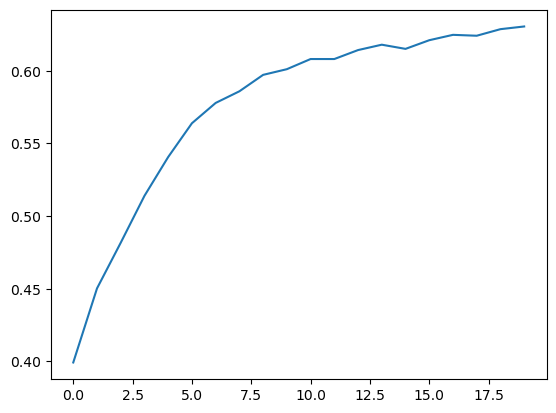

In [ ]:
plt.plot(train_results["test_accs"])


In [ ]:
config["model"]


{'agents': {'ag_dropout': 0.0,
  'cell_type': "<class 'torch.nn.modules.rnn.RNN'>",
  'n_hidden': 50,
  'n_in': 3600,
  'n_layers': 1,
  'n_out': 10,
  'n_readouts': None,
  'train_in_out': [True, True],
  'use_bottleneck': False},
 'common_readout': True,
 'connections': {'binarize': True,
  'comms_dropout': 0.0,
  'comms_start': 'start',
  'sparsity': 0.8,
  'use_deepR': False},
 'n_agents': 2,
 'n_ins': None,
 'n_readouts': 1,
 'readout_from': None}

In [ ]:
plt.plot(train_results["test_accs"])

## Retraining : 

In [ ]:
freeze_retrain = True

task = config["task"] = "inv_parity-digits"
# task = config["task"] = 'both'
# task = config["task"] = [["0", "1"], ["1", "2"], ["0", "2"]]
# task = config["task"] = ["0", "1", "max", "min"]

config["model"]["n_agents"] = 2
config["model"]["agents"]["n_hidden"] = 10
common_readout = config["model"]["common_readout"] = True

configure_readouts(config)

if not freeze_retrain:

    community = init_community(config["model"])

community.n_readouts = config["model"]["n_readouts"]
config["model"]["readout_n_hid"] = 10
config["model"]["connections"]["sparsity"] = 0.0
community.use_common_readout = True

for ag in community.agents:
    ag.dims[-1] = n_classes

community.initialize_readout(
    config["model"]["n_readouts"],
    config["model"]["readout_from"],
    config["model"]["readout_n_hid"],
)

community.to(device)

reg_readout = 1

if freeze_retrain:

    optimizer = torch.optim.AdamW(
        [p for n, p in community.named_parameters() if "readout" in n],
        lr=1e-3,
        weight_decay=reg_readout,
    )

else:
    if not reg_readout:
        optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)
    else:
        optimizer = torch.optim.AdamW(
            [
                p
                for n, p in community.named_parameters()
                if n not in ["readout.0", "readout.1"]
            ],
            lr=1e-3,
        )
        optimizer.add_param_group(
            {
                "params": [
                    p
                    for n, p in community.named_parameters()
                    if n in ["readout.0", "readout.1"]
                ],
                "lr": 1e-3,
                "weight_decay": reg_readout,
            }
        )

data, target = next(iter(loaders[1]))
data, target = process_data(data, target, symbols=True, task=task)
data, target = data.to(device), target.to(device)

out, states, fconns = community(data)

print(out.shape)


In [ ]:
class New_community(nn.Module):
    def __init__(self, community, task="family") -> None:
        super().__init__()
        self.community = community
        self.connections = {}

        if task == "family":
            self.dim_out = [len(get_factors_list(n_agents)), n_classes]
        elif isinstance(task, list):
            self.dim_out = [len(task), n_classes]
        else:
            self.dim_out = [2, n_classes_per_digit]

        self.readout = nn.Linear(20, np.prod(self.dim_out))

    def forward(self, x, conns=0):
        out, states, conns = self.community(x)
        new_out = self.readout(torch.cat([o for o in out[-1]], -1))
        new_out = new_out.reshape(-1, *self.dim_out).transpose(0, 1).unsqueeze(0)

        return new_out, states, conns

In [ ]:
task = config["task"] = "both"
task = config["task"] = ["0", "1", "bitand", "bitor", "max", "min"]

community = init_community(config["model"])


new_com = New_community(community, task).to(device)
new_com.is_community = True


optimizer = torch.optim.AdamW(
    [
        p
        for n, p in new_com.named_parameters()
        if n in ["readout.weight", "readout.bias"]
    ],
    lr=1e-3,
    weight_decay=reg_readout,
)

optimizer = torch.optim.Adam(new_com.parameters(), lr=1e-3)

In [ ]:
data, target = next(iter(loaders[1]))
data, target = process_data(data, target, symbols=True, task=task)
data, target = data.to(device), target.to(device)

new_com(data)[0].shape

In [ ]:
config["training"]["n_epochs"] = 10

train_results = train_community(
    community,
    *loaders,
    optimizers=[optimizer, None],
    config=get_training_dict(config),
    show_all_acc=True,
    use_tqdm=True
)

In [ ]:
if task == "family":
    label = [str(t.data.numpy()) for t in get_factors_list(n_agents)]
elif isinstance(task, list):
    label = task
elif task in ["both", "all"]:
    labem = ["0", "1"]
else:
    label = None
plt.plot(train_results["test_accs"], label=label)
plt.legend()
plt.show()

## Analysis


### Readouts

In [ ]:
if task == "family":
    task_f = [t.data.numpy() for t in get_factors_list(data_config["n_diff_symbols"])]
elif isinstance(task, list):
    task_f = task
else:
    task_f = [task]

fig = plt.figure(constrained_layout=True, figsize=(5 * len(community.readout), 5))
fig.suptitle("Readout Weights")

# create 3x1 subfigs
subfigs = fig.subfigures(1, len(community.readout))
if len(community.readout) == 1:
    subfigs = [subfigs]

for readout, subfig, t in zip(community.readout, subfigs, task_f):

    subfig.suptitle(t)

    if hasattr(readout, "__len__"):

        if hasattr(readout[0], "__len__"):
            axs = subfig.subplots(len(readout[0]) - 1, len(readout))
            for ax_r, r in zip(axs, readout):
                l = 0
                for layer in r:
                    if hasattr(layer, "weight"):
                        ax = ax_r[l]
                        w = layer.weight.cpu().data.numpy()
                        ax.imshow(w)
                        ax.set_title(f"Layer {l}")
                        l += 1
        else:
            axs = subfig.subplots(
                len(readout) - 1 * isinstance(readout, nn.Sequential), 1
            )
            if not hasattr(axs, "__len__"):
                axs = [axs]
            layer = 0
            for r in readout:
                if hasattr(r, "weight"):
                    ax = axs[layer]
                    w = r.weight.cpu().data.numpy()
                    ax.imshow(w)
                    if layer == 0:
                        ax.vlines(
                            [w.shape[1] // 2],
                            -0.01,
                            w.shape[0],
                            color="black",
                            linewidth=2,
                        )
                    ax.set_title(f"Readout {layer}")
                    layer += 1

    else:
        ax = subfig.subplots(1, 1)
        w = readout.weight.cpu().data.numpy()
        ax.vlines([w.shape[1] // 2], -0.01, w.shape[0], color="black", linewidth=2)
        ax.imshow(w)
        ax.set_title(f"{w.mean() :.4E}")

### Global rec Matrix + Com matric

In [ ]:
w_rec_global = community.w_rec_global.data
plt.imshow(w_rec_global)

In [ ]:
abs_w = w_rec_global.abs()
stepI = abs_w.sum(1)
stepII = torch.pow(stepI, -0.5)
stepIII = torch.diag(stepII)
stepIV = torch.matrix_exp(stepIII @ abs_w @ stepIII)
stepIV[torch.eye(abs_w.shape[0], dtype=bool)] = 0

In [ ]:
plt.imshow(stepIV.data.cpu())

## Metrics

### Retraining

In [122]:
diff_metric = lambda c: (c[0] - c[1]) / c.sum()
norms = ["None", 1, 2, "fro", "nuc", np.inf]

In [123]:
from community.funcspec.bottleneck import readout_retrain

steps = ["mid-", "last"]
community.to(device)

bottleneck_metrics = readout_retrain(
    community,
    loaders,
    n_classes,
    n_agents=config["model"]["n_agents"],
    n_digits=data_config["n_diff_symbols"],
    n_epochs=1,
    use_tqdm=True,
    symbols=True,
    force_connections=False,
    chosen_timesteps=steps,
    n_hid=30,
)

Bottleneck Metric Trials :   0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/1 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/1 [00:00<?, ?it/s]

In [124]:
det = lambda M: np.abs(np.linalg.det(M))


def plot_metric(metric):

    n_steps = len(metric)
    fig, axs = plt.subplots(1, n_steps, figsize=(10, 3), constrained_layout=True)

    if n_steps == 1:
        axs = [axs]

    for s, ax in enumerate(axs):

        im = ax.imshow(metric[s])

        ax.set_ylabel("agents")
        ax.set_xlabel("Task")

        ax.set_xticks(range(len(metric[s])))
        ax.set_yticks(range(len(metric[s])))

        fig.colorbar(im, ax=ax)

        ax.set_title(
            f"Det = {det(metric[s]) :.3E} \n Normed Det = {det(metric[s]) / metric[s].sum(0).prod() :.3E}"
        )


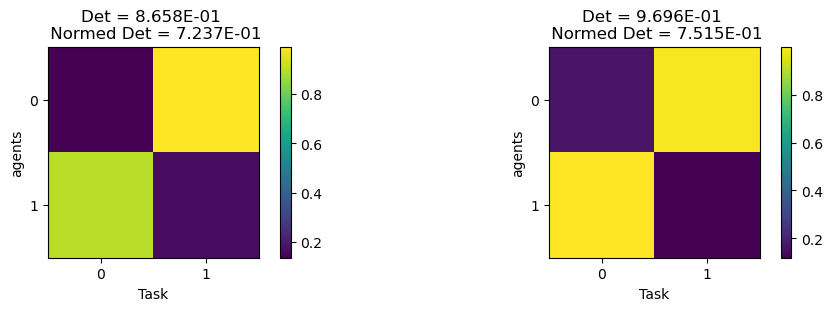

In [125]:
plot_metric(np.stack([bottleneck_metrics["accs"][:, :, s] for s in range(len(steps))]))

### Return of the masks

In [ ]:
from community.funcspec.masks import (
    train_and_get_mask_metric,
    Mask_Community,
    get_proportions,
    get_proportions_per_agent,
    GetSubnet_global,
    find_optimal_sparsity,
    train_mask,
)

In [ ]:
mask_metrics, masked_coms = train_and_get_mask_metric(
    community,
    0.2,
    loaders,
    n_tests=1,
    n_epochs=2,
    lr=1e-1,
    use_optimal_sparsity=False,
    device=torch.device("cuda"),
    use_tqdm=True,
    symbols=True,
    include_ih=False,
    decision_params=config["training"]["decision_params"],
    chosen_timesteps=["last"],
    multi_objectives=True,
)

In [ ]:
plot_metric(mask_metrics["proportions"].transpose(-1, 0, 1))

In [ ]:
masked_com = Mask_Community(
    community, sparsity=1, include_ih=False, include_readout=True
)
# masked_com.load_state_dict(mask_metrics["best_states"][-1][0])
masked_com.proportions

In [ ]:
target_digit = "0"
decision_params = config["training"]["decision_params"]
use_tqdm = True
symbols = True
ts = "last"

if type(use_tqdm) is int:
    position = use_tqdm
    use_tqdm = True
elif use_tqdm:
    position = 0

d_params = decision_params[::]
d_params[0] = ts
if "all" in decision_params:
    d_params[1] = target_digit


def test_masked_com():

    training_dict = {
        "n_epochs": 1,
        "task": str(target_digit),
        "global_rewire": False,
        "check_gradients": False,
        "reg_factor": 0.0,
        "train_connections": False,
        "decision_params": d_params,
        "stopping_acc": None,
        "early_stop": False,
        "deepR_params_dict": {},
        "data_type": "symbols" if symbols else None,
        "force_connections": False,
        "n_classes": n_classes,
        "n_classes_per_digit": n_classes,
    }

    train_out = train_community(
        masked_community,
        *loaders,
        (None, None),
        config=training_dict,
        device=device,
        trials=(False, True),
        use_tqdm=False,
    )
    return train_out


masked_community = Mask_Community(
    community, sparsity=1, include_ih=False, include_readout=True
).to(device)

max_out = test_masked_com()
max_acc = max_out["test_accs"].max()
min_acc = 0.9 * max_acc
print(f"For Sparsity of 1, acc is {max_acc}")


def train_com(sparsity):

    return train_mask(
        community,
        sparsity,
        loaders,
        target_digit,
        decision_params,
        n_epochs=1,
        lr=1e-3,
        device=device,
        use_tqdm=False,
        symbols=True,
        include_ih=False,
    )


sparsity = 0.8
masked_community, losses, accs, state = train_com(sparsity)

test_acc = accs.max()
pbar = tqdm(total=10, position=position, leave=None)

pbar.set_description(
    f"For Mask of Sparsity {masked_community.sparsity}, Acc is {test_acc}, min_acc = {min_acc}"
)

while True:
    # print(test_acc, masked_community.sparsity)
    # masked_community.set_sparsity(masked_community.sparsity * 0.9)
    # train_out = test_masked_com()
    # test_acc = train_out["test_accs"].max()

    sparsity *= 0.9
    masked_community, losses, accs, state = train_com(sparsity)
    test_acc = accs.max()
    pbar.set_description(
        f"For Mask of Sparsity {masked_community.sparsity}, Acc is {test_acc}"
    )
    pbar.update(1)

In [ ]:
initial_s

In [ ]:
masked_community.subnets

In [ ]:
total = np.sum([s.data.mean() for n, s in masked_com.subnets.items()])
total

In [ ]:
[
    np.mean([s.data.mean() for n, s in masked_com.subnets.items() if n[7] == str(i)])
    / total
    for i in range(2)
]

In [ ]:
np.mean([s.data.mean() for n, s in subnets.items() if n[7] == "0"]) / (
    2 * np.mean([s.data.mean() for n, s in subnets.items()])
)

In [ ]:
np.mean([s.data.mean() for n, s in subnets.items()])

In [ ]:
get_proportions(masked_com).items()

In [ ]:
community.best_acc

In [ ]:
mask_metrics["test_accs"]

### Shapley Values

In [15]:
from msapy import msa, utils as ut
from community.common.decision import get_decision
from community.common.training import get_loss
from shapley import compute_shapley_values
from functools import partial

In [16]:
nodes = list(np.arange(n_agents * config["model"]["agents"]["n_hidden"]).astype(str))

In [49]:
shapley_compute = True
shapley_recompute = True
shapley_save = True

n_permutations = 100

try:
    saved_shapley = torch.load("saves/shapley")
    shapley_tables = saved_shapley[str(config)]

    if shapley_recompute:
        (
            shapley_tables,
            shapley_tables_avg,
            all_accs,
            contributions,
            lesion_effects,
        ) = compute_shapley_values(
            community,
            nodes,
            n_permutations,
            datasets,
            config,
        )

    if shapley_save:
        saved_shapley[str(config)] = shapley_tables
        torch.save(saved_shapley, "saves/shapley")

except FileNotFoundError:
    # config["task"] = [str(i) for i in range(n_agents)]

    if shapley_compute:

        (
            shapley_tables,
            shapley_tables_avg,
            all_accs,
            contributions,
            lesion_effects,
        ) = compute_shapley_values(
            community,
            nodes,
            n_permutations,
            datasets,
            config,
        )

    if shapley_save:
        saved_shapley = {}
        saved_shapley[str(config)] = shapley_tables
        torch.save(saved_shapley, "saves/shapley")

except KeyError:

    if shapley_compute:

        (
            shapley_tables,
            shapley_tables_avg,
            all_accs,
            contributions,
            lesion_effects,
        ) = compute_shapley_values(
            community,
            nodes,
            n_permutations,
            datasets,
            config,
        )

    if shapley_save:
        saved_shapley[str(config)] = shapley_tables
        torch.save(saved_shapley, "saves/shapley")


Task 0 : Performance without ablations : [0.9472656]


100%|██████████| 4785/4785 [00:43<00:00, 110.13it/s]


Task 1 : Performance without ablations : [0.9902344]


100%|██████████| 4785/4785 [00:40<00:00, 118.47it/s]


In [54]:
tasks = [np.full_like(shap, t, dtype=object) for shap, t in zip(shapley_tables_avg, ['0', '1'])]

In [56]:
import pandas as pd

In [57]:
{shapley_tables_avg[0][i]}

{0.0}

In [68]:
avg_shap_pd = pd.DataFrame.from_dict({'node' : nodes, 'task_0' : shapley_tables_avg[0], 'task_1' : shapley_tables_avg[1]})

<AxesSubplot: xlabel='node'>

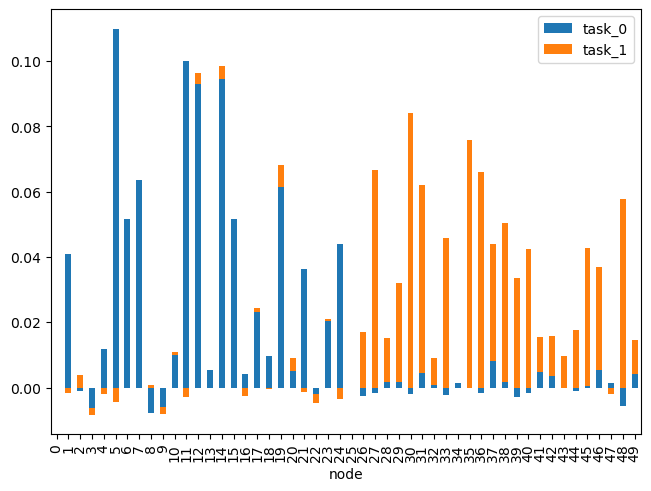

In [70]:
fig, ax = plt.subplots(constrained_layout=True)
avg_shap_pd.plot(x='node', kind='bar', stacked=True, ax=ax)


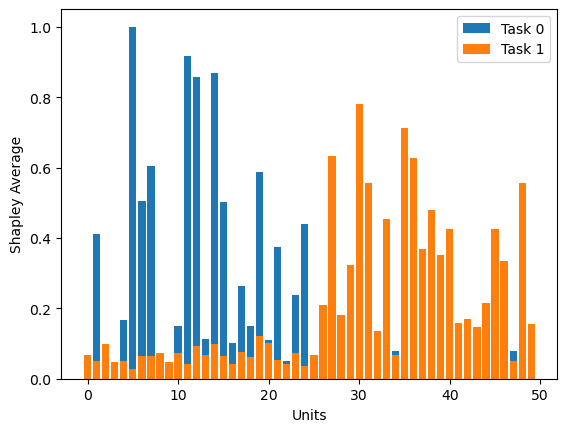

In [65]:
norm = lambda a:  (a - np.min(a)) / np.ptp(a)

maximum = np.max([s.mean() for s in shapley_tables])

for shap, task in zip(norm(shapley_tables_avg), ["0", "1"]):
    plt.bar(np.arange(len(nodes)), shap, label=f"Task {task}")

# plt.vlines([len(nodes) // 2], [-0.02], [maximum * 1.2], "black", "--", alpha=0.3)
plt.legend()
plt.xlabel("Units")
plt.ylabel("Shapley Average")
plt.show()

In [ ]:
np.ptp(shapley_tables_avg)


0.05214844

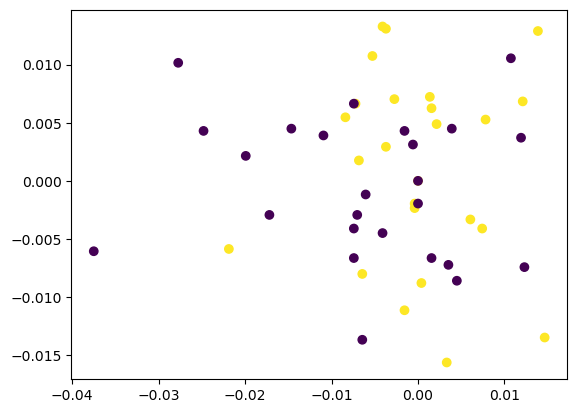

In [ ]:
plt.scatter(
    shapley_tables_avg[0],
    shapley_tables_avg[1],
    c=np.arange(shapley_tables_avg[0].shape[0]) < shapley_tables_avg[0].shape[0] // 2,
)

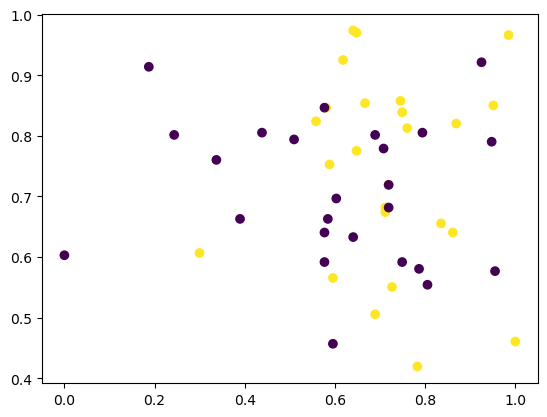

In [ ]:
plt.scatter(
    norm(shapley_tables_avg)[0],
    norm(shapley_tables_avg)[1],
    c=np.arange(shapley_tables_avg[0].shape[0]) < shapley_tables_avg[0].shape[0] // 2,
)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

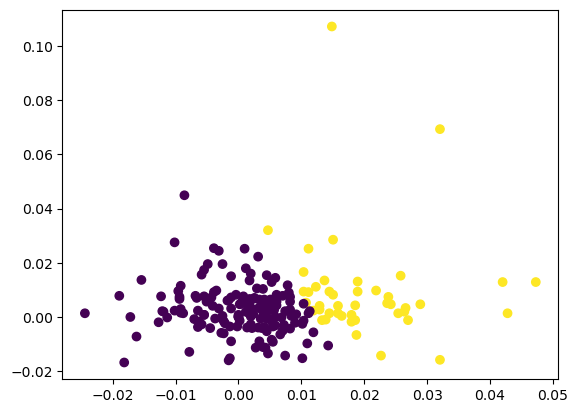

In [ ]:
km = KMeans(2)
all_shapley = pd.concat(shapley_tables_avg, axis=1)
km.fit(all_shapley)
kmeans_labels = km.labels_

plt.scatter(shapley_tables_avg[0], shapley_tables_avg[1], c=kmeans_labels)


In [ ]:
shapley_table, contributions, lesion_effects = msa.interface(
    multiprocessing_method="joblib",
    elements=nodes,
    n_permutations=10,
    objective_function=masked_inference,
    n_parallel_games=24,
)


# Stability

In [ ]:
for ag in community.agents:
    eigens = torch.linalg.eigvals(ag.w_rec).cpu().data
    plt.figure()
    plt.scatter(eigens.real, eigens.imag)

In [ ]:
for state in states.transpose(0, 1).cpu():
    plt.figure()
    for s in state.transpose(0, -1):
        plt.plot(range(6), s.mean(0).cpu().data)

# New Data Gen

In [ ]:
labels, centers = datasets[0].data[1:]
centers = centers.transpose(0, 1)
symbols = datasets[0].symbols
symbol_size = datasets[0].symbol_size
centers.shape

In [ ]:
data_size = 10000
input_size = 60
n_steps = centers.shape[0]
n_symbols = centers.shape[-2]
symbol_assignments = [datasets[0].get_random_symbol_assignement(l) for l in labels]

In [ ]:
def fill_grid(idxs):
    # grids = np.zeros((n_steps, data_size, input_size, input_size))
    time_step, data_idx, symbol = idxs
    center_pos = centers[time_step, data_idx, symbol]
    label = symbol_assignments[data_idx][symbol]
    grids[
        time_step,
        data_idx,
        center_pos[0] : center_pos[0] + symbol_size,
        center_pos[1] : center_pos[1] + symbol_size,
    ] += symbols[label]
    # return grids


@ray.remote
def fill_grid_data(time_step):

    grids = np.zeros((data_size, input_size, input_size))
    for data_idx in range(data_size):
        for symbol in range(n_symbols):
            center_pos = centers[time_step, data_idx, symbol]
            label = symbol_assignments[data_idx][symbol]
            grids[
                data_idx,
                center_pos[0] : center_pos[0] + symbol_size,
                center_pos[1] : center_pos[1] + symbol_size,
            ] += symbols[label]

    return grids


def old_method():
    grids = []

    def assign_square(grid, center_pos, l, d):
        grid[
            d,
            center_pos[0] : center_pos[0] + symbol_size,
            center_pos[1] : center_pos[1] + symbol_size,
        ] += symbols[l]

    for center in centers:
        grid = np.zeros((data_size, input_size, input_size))
        for d in range(data_size):
            for i, c in enumerate(center[d]):
                # l = int(i < labels[d])
                assign_square(grid, (c[0], c[1]), symbol_assignments[d][i], d)

        grids.append(grid)

    grids = np.stack(grids)

    return grids


time_data_and_sym = [
    [t, d, i]
    for t in range(n_steps)
    for d in range(data_size)
    for i in range(n_symbols)
]

In [ ]:
import ray

num_cpus = 24

grids = np.zeros((n_steps, data_size, input_size, input_size))

grids_id = ray.put(grids)


prof = profile.Profile()
prof.enable()

grids = np.stack(ray.get([fill_grid_data.remote(idx) for idx in range(n_steps)]))
print(grids.shape)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows

In [ ]:
grids = np.zeros((n_steps, data_size, input_size, input_size))
vect_fill = np.vectorize(fill_grid, signature="(N)->()")

prof = profile.Profile()
prof.enable()

grids = vect_fill(time_data_and_sym)
print(grids.shape)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows

In [ ]:
grids = np.zeros((n_steps, data_size, input_size, input_size))

prof = profile.Profile()
prof.enable()

grids = [fill_grid(idx) for idx in time_data_and_sym]

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows

In [ ]:
prof = profile.Profile()
prof.enable()

grids_old = old_method()
print(grids_old.shape)
prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows

In [ ]:
from joblib import delayed, Parallel

In [ ]:
prof = profile.Profile()
prof.enable()

grids = np.stack([fill_grid_data(d) for d in trange(n_steps)])
grids.shape

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows

In [ ]:
prof = profile.Profile()
prof.enable()

grids = np.stack(
    Parallel(24, max_nbytes=1e12, backend="multiprocessing")(
        delayed(fill_grid_data)(idx) for idx in trange(n_steps)
    )
)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows